# Raw Data Extraction

Creating dataset with images and labels from the pure set of videos and the json file.

In [1]:
from src.data import process_all_splits

In [2]:
VIDEO_ROOT = "C:\\Users\\sandr\\Downloads\\trailer\\trailer"
JSON_PATH = "C:\\Users\\sandr\\Downloads\\v1_split_trailer.json"
IMAGE_QUALITY = 15
OUTPUT_DIR = "./data"

In [ ]:
extrac_data = False
if extrac_data:
    process_all_splits(VIDEO_ROOT, JSON_PATH, IMAGE_QUALITY, OUTPUT_DIR) # took 1h and 8 minutes with ≈8frames/s

Extracting Frames: 100%|██████████| 33653/33653 [1:08:51<00:00,  8.15frame/s]


# Dataset Creation

In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.data import LensTypeDataset
from collections import Counter

SEED = 42
torch.manual_seed(SEED)

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

noise_stds = [0.05, 0.1, 0.2, 0.4, 0.5]
noisy_percentage = 0.4

train_dataset = LensTypeDataset(root_dir="./data", split="train", transform=transform, noise_stds=noise_stds, noisy_percentage=noisy_percentage)
val_dataset = LensTypeDataset(root_dir="./data", split="val", transform=transform, noisy_percentage=0.0)
test_dataset = LensTypeDataset(root_dir="./data", split="test", transform=transform, noisy_percentage=0.0)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [3]:
print(f"Images in train: {len(train_dataset)}")
print(f"Images in val: {len(val_dataset)}")
print(f"Images in test: {len(test_dataset)}")
print(f"Total number of images: {len(test_dataset) + len(val_dataset) + len(train_dataset)}")

Images in train: 20856
Images in val: 4610
Images in test: 8187
Total number of images: 33653


In [4]:
print(f"Train label count: {Counter(train_dataset.labels)}")
print(f"Val label count: {Counter(val_dataset.labels)}")
print(f"Test label count: {Counter(test_dataset.labels)}")

Train label count: Counter({2: 4650, 1: 4529, 3: 4275, 0: 3946, 4: 3456})
Val label count: Counter({1: 1049, 2: 1006, 0: 922, 3: 886, 4: 747})
Test label count: Counter({1: 1792, 2: 1753, 3: 1642, 0: 1641, 4: 1359})


In [5]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 3, 224, 224]) torch.Size([64])


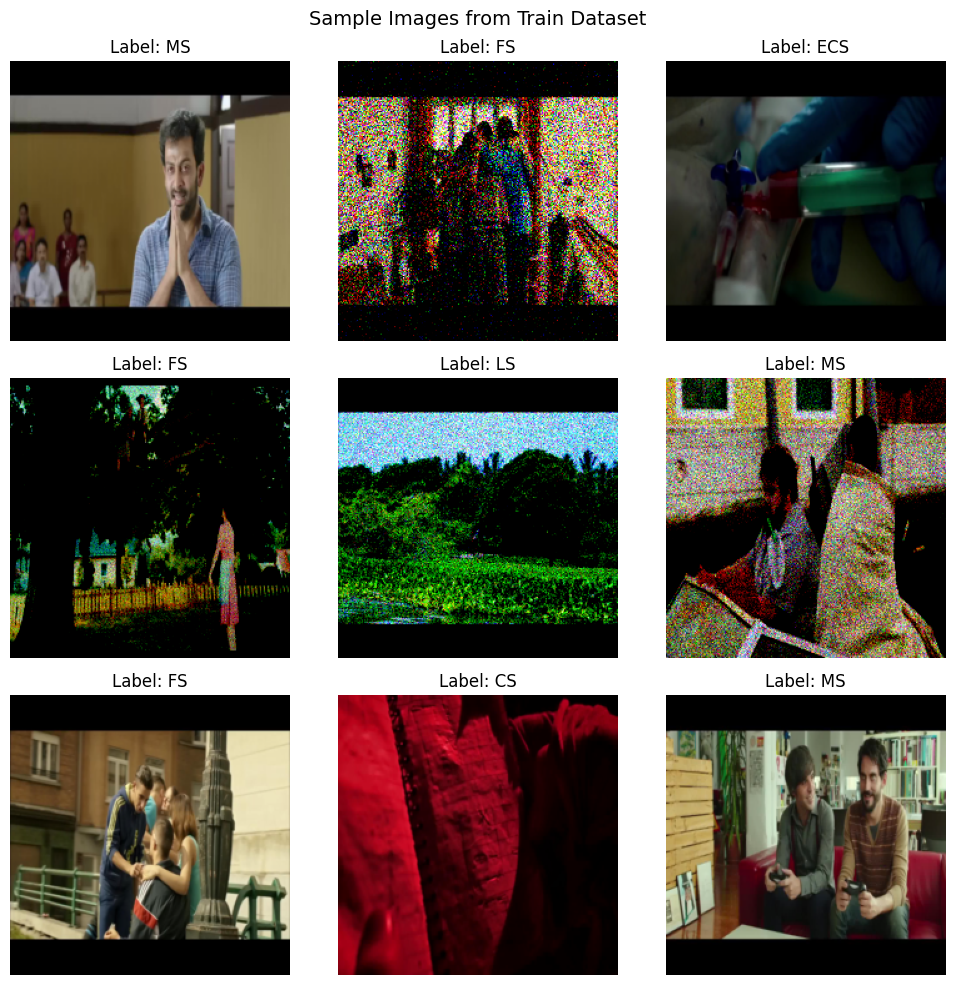

In [6]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("Sample Images from Train Dataset", fontsize=14)

label_mapping = {0: "ECS", 1: "CS", 2: "MS", 3: "FS", 4: "LS"}

for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).numpy()  # (C, H, W) to (H, W, C)
    img = (img - img.min()) / (img.max() - img.min())

    ax.imshow(img)
    ax.set_title(f"Label: {label_mapping[labels[i].item()]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Fine-tuning

Now let's train the classifier, which we will use later for the guidance in the image generation.